In [1]:
import pickle
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt # Añadimos esto para visualizar en el notebook

In [11]:
class SignalDataset(Dataset):
    def __init__(self, path, min_snr=0, exclude_qpsk=True):
        # 1. Cargar el archivo original
        with open(path, 'rb') as f:
            d = pickle.load(f, encoding='latin1')
        
        self.X = []
        self.lbl = []
        
        # 2. Definir las clases (Modulaciones)
        all_mods = sorted(list(set(map(lambda x: x[0], d.keys()))))
        
        if exclude_qpsk:
            self.mods = [m for m in all_mods if m != 'QPSK']
            print(f"🚫 Clase 'QPSK' excluida del entrenamiento.")
        else:
            self.mods = all_mods
            
        print(f"📡 Clases a entrenar ({len(self.mods)}): {self.mods}")
        print(f"🔍 Filtrando señales con SNR >= {min_snr}dB...")
        
        # 3. Procesar y filtrar los datos
        for mod in self.mods:
            snrs = sorted(list(set(map(lambda x: x[1], d.keys()))))
            for snr in snrs:
                if snr >= min_snr:
                    samples = d[(mod, snr)]
                    self.X.append(samples)
                    for i in range(samples.shape[0]):
                        # La etiqueta es el índice dentro de nuestra lista filtrada
                        self.lbl.append(self.mods.index(mod))
        
        # 4. Convertir a tensores de PyTorch
        self.X = np.vstack(self.X)
        self.X = torch.from_numpy(self.X).float()
        self.lbl = torch.tensor(self.lbl).long()
        
        print(f"✅ Proceso terminado. Total de muestras: {len(self.lbl)}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.lbl[idx]

In [3]:
def get_loaders(path, batch_size=1024, min_snr=0, exclude_qpsk=True):
    # Creamos el dataset con los filtros aplicados
    full_dataset = SignalDataset(path, min_snr=min_snr, exclude_qpsk=exclude_qpsk)
    
    # Dividimos: 80% entrenamiento, 20% validación
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    
    # Configuramos los cargadores para la GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, full_dataset.mods

In [4]:
import os

# 1. Intentamos las dos rutas posibles
ruta_local = "data/raw/RML2016.10a_dict.pkl"
ruta_superior = "../data/raw/RML2016.10a_dict.pkl"

if os.path.exists(ruta_local):
    PATH = ruta_local
elif os.path.exists(ruta_superior):
    PATH = ruta_superior
else:
    PATH = None

# 2. Ejecutar la carga solo si encontramos el archivo
if PATH:
    print(f"✅ Archivo encontrado en: {PATH}")
    # ¡Asegúrate de ejecutar la celda donde definiste get_loaders antes de esta!
    train_loader, test_loader, mods = get_loaders(PATH, min_snr=0, exclude_qpsk=True)
    
    print(f"\n📊 Resumen del Notebook:")
    print(f"Clases cargadas: {len(mods)}")
    print(f"Batches en entrenamiento: {len(train_loader)}")
else:
    print("❌ ERROR: El archivo NO se encuentra en ninguna de las rutas.")
    print(f"📍 Tu ubicación actual es: {os.getcwd()}")
    print(f"📁 Archivos que veo aquí: {os.listdir('.')}")

✅ Archivo encontrado en: ../data/raw/RML2016.10a_dict.pkl
🚫 Clase 'QPSK' excluida del entrenamiento.
📡 Clases a entrenar (10): ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'WBFM']
🔍 Filtrando señales con SNR >= 0dB...
✅ Proceso terminado. Total de muestras: 100000

📊 Resumen del Notebook:
Clases cargadas: 10
Batches en entrenamiento: 79


✅ Imagen guardada en: c:\Users\ivanb\OneDrive\Desktop\proyectos\ia_vision\img\ejemplo_CPFSK.png


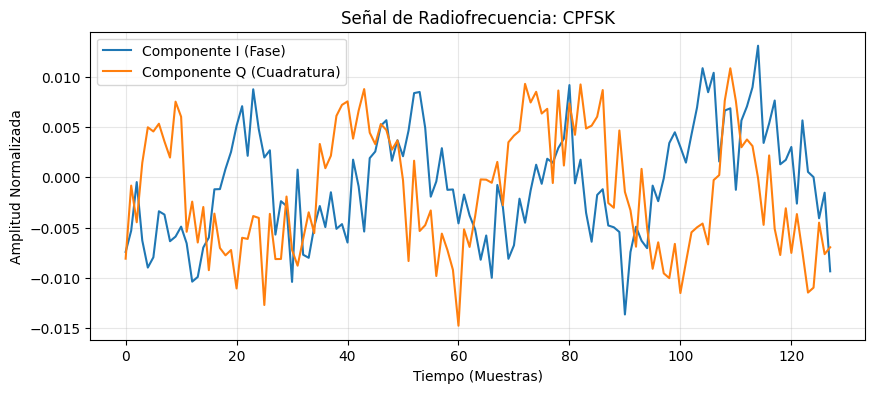

In [26]:
# 1. Sacar una señal de ejemplo
signals, labels = next(iter(train_loader))
signal = signals[0].numpy()
label = labels[0].item()
nombre_modulacion = mods[label]

# 2. Configurar la ruta de guardado (subiendo a la raíz y entrando a img/)
IMG_DIR = "../img"
os.makedirs(IMG_DIR, exist_ok=True) # Crea la carpeta si no existe
FILE_PATH = os.path.join(IMG_DIR, f"ejemplo_{nombre_modulacion}.png")

# 3. Graficar
plt.figure(figsize=(10, 4))
plt.plot(signal[0], label='Componente I (Fase)')
plt.plot(signal[1], label='Componente Q (Cuadratura)')
plt.title(f"Señal de Radiofrecuencia: {nombre_modulacion}")
plt.xlabel("Tiempo (Muestras)")
plt.ylabel("Amplitud Normalizada")
plt.legend()
plt.grid(alpha=0.3)

# 4. Guardar y mostrar
plt.savefig(FILE_PATH, dpi=300, bbox_inches='tight') # dpi=300 para alta calidad
print(f"✅ Imagen guardada en: {os.path.abspath(FILE_PATH)}")
plt.show()

In [20]:
import os

# 1. Lista de posibles rutas (ajustadas a tu estructura)
posibles_rutas = [
    "data/raw/RML2016.10a_dict.pkl",       # Ruta directa
    "../data/raw/RML2016.10a_dict.pkl",    # Subiendo un nivel
    "../../data/raw/RML2016.10a_dict.pkl" # Subiendo dos niveles
]

PATH_REAL = None

for ruta in posibles_rutas:
    if os.path.exists(ruta):
        PATH_REAL = ruta
        break

# 2. Verificar y Cargar
if PATH_REAL:
    print(f"✅ Archivo encontrado en: {PATH_REAL}")
    # Creamos el objeto dataset
    full_dataset = SignalDataset(PATH_REAL, min_snr=0, exclude_qpsk=True)
    print("✅ Objeto 'full_dataset' creado exitosamente.")
else:
    print("❌ ERROR: No se encontró el archivo .pkl en ninguna ruta conocida.")
    print(f"📍 Tu ubicación actual es: {os.getcwd()}")
    # Listamos carpetas para ayudarte a ver dónde estás
    print(f"📁 Carpetas aquí: {os.listdir('.')}")

✅ Archivo encontrado en: ../data/raw/RML2016.10a_dict.pkl
🚫 Clase 'QPSK' excluida del entrenamiento.
📡 Clases a entrenar (10): ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'WBFM']
🔍 Filtrando señales con SNR >= 0dB...
✅ Proceso terminado. Total de muestras: 100000
✅ Objeto 'full_dataset' creado exitosamente.


In [19]:
import os
import torch


# 1. Corregimos la ruta (usando la barra / después de los puntos)
FOLDER_PATH = "../data/processed" 
os.makedirs(FOLDER_PATH, exist_ok=True)

SAVE_PATH = os.path.join(FOLDER_PATH, "RML2016_limpio.pt")

# 2. Intentar guardar
try:
    data_to_save = {
        'X': full_dataset.X,
        'lbl': full_dataset.lbl,
        'mods': full_dataset.mods
    }
    
    torch.save(data_to_save, SAVE_PATH)

    print(f"✅ ¡Datos pre-procesados guardados con éxito!")
    print(f"📍 Ruta: {os.path.abspath(SAVE_PATH)}")
    print(f"📊 Muestras: {len(full_dataset.lbl)}")
    print(f"📡 Clases: {full_dataset.mods}")

except NameError:
    print("❌ Error: No se encontró la variable 'full_dataset'.")
    print("👉 SOLUCIÓN: Ejecuta la celda de arriba donde definimos 'full_dataset = SignalDataset(...)'")

✅ ¡Datos pre-procesados guardados con éxito!
📍 Ruta: c:\Users\ivanb\OneDrive\Desktop\proyectos\ia_vision\data\processed\RML2016_limpio.pt
📊 Muestras: 100000
📡 Clases: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'WBFM']
